# QT Quality

Note: Run in prod environment to get prod QT data.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from asyncio import Semaphore
from openai import AsyncOpenAI
from dotenv import load_dotenv
from tqdm.asyncio import tqdm_asyncio
from tqdm.notebook import tqdm

In [2]:
import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger("httpx").setLevel(logging.WARNING)

In [3]:
from sqlmodel import Session, select
from ypl.backend.db import get_engine

from sqlalchemy import func, case, or_, and_
from ypl.db.chats import MessageType, User, Category, Chat, Turn, ChatMessage, MessageEval
from ypl.db.language_models import LanguageModel

with Session(get_engine()) as session:
    qt_messages_query = (
        session.query(
            User.name,
            Chat.created_at,
            Chat.chat_id,
            Turn.turn_id,
            Turn.sequence_id,
            MessageEval.score,
            LanguageModel.name.label('assistant_model_name'),
            case(
                (or_(ChatMessage.content == '', func.length(ChatMessage.content) > 140), '[NULL]'),
                else_=ChatMessage.content
            ).label('qt_response'),
        )
        .join(Turn, ChatMessage.turn_id == Turn.turn_id)
        .join(Chat, Turn.chat_id == Chat.chat_id)
        .outerjoin(LanguageModel, ChatMessage.assistant_language_model_id == LanguageModel.language_model_id)
        .outerjoin(MessageEval, ChatMessage.message_id == MessageEval.message_id)
        .outerjoin(User, Chat.creator_user_id == User.user_id)
        .filter(ChatMessage.message_type == MessageType.QUICK_RESPONSE_MESSAGE)
        .order_by(Chat.created_at.desc(), Turn.sequence_id)
    )

    user_messages_query = (
        session.query(
            Turn.turn_id,
            ChatMessage.content.label('prompt'),
            Category.name.label('category')
        )
        .join(Turn, ChatMessage.turn_id == Turn.turn_id)
        .outerjoin(Category, ChatMessage.category_id == Category.category_id)
        .filter(ChatMessage.message_type == MessageType.USER_MESSAGE)
    )

    qt_messages_df = pd.DataFrame(qt_messages_query.all())
    user_messages_df = pd.DataFrame(user_messages_query.all())

    df = pd.merge(qt_messages_df, user_messages_df, on='turn_id', how='left')
    df['chat_id'] = df['chat_id'].astype(str)
    df['turn_id'] = df['turn_id'].astype(str)

ERROR:root:Google Cloud Logging setup failed: Your default credentials were not found. To set up Application Default Credentials, see https://cloud.google.com/docs/authentication/external/set-up-adc for more information.


In [4]:
def get_history_up_to_row(row):
    chat_messages = df[
        (df['chat_id'] == row['chat_id']) & 
        (df['sequence_id'] < row['sequence_id'])
    ].sort_values('sequence_id')

    history = []
    for _, msg in chat_messages.iterrows():
        history.append({"role": "user", "content": msg['prompt']})
        history.append({"role": "assistant", "content": msg['qt_response']})
    return history

def create_chat_histories(df):
    # Create a new column with chat histories
    df = df.sort_values(['chat_id', 'sequence_id'])
    df['chat_history'] = df.apply(get_history_up_to_row, axis=1)
    return df.reset_index(drop=True)

df = create_chat_histories(df)

In [5]:
# QT responses from prod
df

,name,created_at,chat_id,turn_id,sequence_id,score,assistant_model_name,qt_response,prompt,category,chat_history
0,Gilad Mishne,2024-08-31 02:53:23.565000+00:00,0003edfd-a23e-4c18-958a-312d7cdff38f,10bba073-3aaf-49d3-a816-18d88b35590f,0,NaN,gpt-4-turbo,Ball size: Basketball larger; Soccer smaller.\...,compare basketball and soccer in terms of ball...,Comparison,[]
1,Minqi Chen,2024-10-03 05:45:41.949000+00:00,00041ff0-482d-42e4-833d-73e968e45e11,c0079b91-ed0d-4b99-88d3-463a6f603bc3,0,NaN,gpt-4o,"20-30 boxes, depending on how much stuff you h...",How many moving boxes for a 2b apartment move,Factual,[]
2,Minqi Chen,2024-09-24 22:15:13.739000+00:00,00077365-2762-47b7-8a57-f720dad1a087,c5945772-f602-4558-af18-095b72b12f0a,0,NaN,gpt-4-turbo,file.test.ts,"should vitest tests be named as file.test.ts, ...",Opinion,[]
3,Minqi Chen,2024-09-24 22:15:13.739000+00:00,00077365-2762-47b7-8a57-f720dad1a087,9f1d93c1-d748-476c-b232-3ca57084daa0,1,NaN,gpt-4o,[NULL],write an example unit test in vitest for react,Code,"[{'role': 'user', 'content': 'should vitest te..."
4,Pankaj Gupta,2024-11-23 21:34:27.884000+00:00,001eea46-32a6-4a68-8f05-6131e0f9de64,d81657c9-dba5-4689-a452-9ea59d656be7,0,0.0,gpt-4o-mini,[NULL],Airport porm,Creative Writing,[]
...,...,...,...,...,...,...,...,...,...,...,...
6211,Bhanu Chandra,2024-10-31 07:01:18.954000+00:00,ffc0629d-401f-4054-b553-4541187d184a,552c79c0-26d6-4a41-9d6d-e4e2bd9c9567,0,NaN,gpt-4o,"Yes, typically.",does foreign key automatically create an index?,Factual,[]
6212,Carmen Lai,2024-10-24 19:59:21.689000+00:00,ffc98238-fef9-4013-87c5-7280685bb1d0,5aa4b1e3-482e-4cd3-be75-c4c44f0c99aa,0,NaN,gemini-1.5-flash-8b,Greetings!\n,hello?,Other,[]
6213,Gilad Mishne,2024-09-16 07:40:46.675000+00:00,ffd3274d-8fbf-4c0e-a439-c4e0549d73f3,abccf931-e013-4eaa-b8e4-9c20cd07ad59,0,NaN,gpt-4-turbo,e|-0-|\nB|-1-|\nG|-2-|\nD|-2-|\nA|-0-|\nE|---|,make an ascii representation of the Am fingeri...,Creative Writing,[]
6214,Gilad Mishne,2024-09-16 07:40:46.675000+00:00,ffd3274d-8fbf-4c0e-a439-c4e0549d73f3,62fdb6c1-5538-4780-af43-bd8db2a38191,1,NaN,gpt-4-turbo,e|-0-|\nB|-0-|\nG|-0-|\nD|-2-|\nA|-2-|\nE|-0-|,ok now Em11,Other,"[{'role': 'user', 'content': 'make an ascii re..."


In [6]:
# Load API key
env_local_path = "../../sarai-chat/.env.local"
load_dotenv(env_local_path)
api_key = os.getenv("OPENAI_API_KEY")
client = AsyncOpenAI(api_key=api_key)

In [7]:
async def chat_complete(
    user_prompt: str, 
    system_prompt: str = "", 
    model: str = "gpt-4o-mini", 
    temperature: float = 0, 
    max_tokens: int | None = None,
    sem: Semaphore = None
) -> str:
    sem = sem or Semaphore(1)
    try:
        async with sem:
            sys_prefix = [dict(role="system", content=system_prompt)] if system_prompt else []
            messages = sys_prefix + [dict(role="user", content=user_prompt)]
            response = await client.chat.completions.create(
                messages=messages,
                model=model,
                temperature=temperature,
                max_tokens=max_tokens,
            )
            return response.choices[0].message.content
    except Exception as e:
        print(e)
        print(user_prompt)
        print("")
        return ""

async def batch_complete(prompts: list[str], system_prompt: str = "", **kwargs):
    sem = Semaphore(5)  # 5 concurrent max
    return await tqdm_asyncio.gather(
        *[chat_complete(prompt, system_prompt=system_prompt, sem=sem, **kwargs) 
          for prompt in prompts]
    )

In [9]:
from ypl.backend.prompts import JUDGE_QT_QUALITY_SYSTEM_PROMPT, JUDGE_QT_QUALITY_USER_PROMPT

JUDGE_MODEL = "gpt-4o-mini"

# Prepare all prompts and histories first
prompts = []
for _, row in df.iterrows():
    # Format chat history as a string, only if there is history
    chat_history_str = "\n".join(
        f"{msg['role'].capitalize()}: {msg['content']}" for msg in row.chat_history
    ) if row.chat_history else "No previous conversation history"
    
    prompt = JUDGE_QT_QUALITY_USER_PROMPT.format(
        chat_history=chat_history_str,
        response=row.qt_response,
        user_prompt=row.prompt
    )
    prompts.append(prompt)

# Batch process all prompts with their histories
raw_judgments = await batch_complete(prompts, system_prompt=JUDGE_QT_QUALITY_SYSTEM_PROMPT, model=JUDGE_MODEL)
# Convert numeric ratings to categories
judgments = []
for judgment in raw_judgments:
    quality = None
    if "1" in judgment:
        quality = "poor"
    elif "2" in judgment:
        quality = "acceptable"
    elif "3" in judgment:
        quality = "excellent"
    judgments.append(quality)

# Add judgments to DataFrame
df['quality'] = judgments

  2%|▏         | 145/6216 [00:30<08:24, 12.03it/s]

In [42]:
# Reload data as needed (saved below)
df = pd.read_csv('data/qt_responses_20241205_with_quality.csv').infer_objects()
df['created_at'] = pd.to_datetime(df['created_at'], format='ISO8601', utc=True)

import ast
df['chat_history'] = df['chat_history'].apply(ast.literal_eval)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6213 entries, 0 to 6212
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   name                  6213 non-null   object             
 1   created_at            6213 non-null   datetime64[ns, UTC]
 2   chat_id               6213 non-null   object             
 3   turn_id               6213 non-null   object             
 4   sequence_id           6213 non-null   int64              
 5   score                 107 non-null    float64            
 6   assistant_model_name  6213 non-null   object             
 7   qt_response           6212 non-null   object             
 8   prompt                6213 non-null   object             
 9   category              6163 non-null   object             
 10  chat_history          6213 non-null   object             
 11  quality               6208 non-null   object             
 12  qualit

In [19]:
df['quality'].value_counts()

quality
excellent     4255
poor          1112
acceptable     841
Name: count, dtype: int64

In [20]:
df['quality_is_excellent'] = df['quality'] == 'excellent'
df['created_date'] = pd.to_datetime(pd.to_datetime(df['created_at']).dt.date)

In [ ]:
# Save as checkpoint
df.to_csv('data/qt_responses_20241205_with_quality.csv', index=False)

In [21]:
df['quality_is_excellent'].mean()

0.68485433767906

In [29]:
df.groupby('category')['quality_is_excellent'].mean().sort_values(ascending=False)

category
Advice              0.897321
Entertainment       0.878173
Comparison          0.788194
Factual             0.783314
Opinion             0.738806
Multilingual        0.709302
Code                0.695055
Other               0.604039
Education           0.597610
Creative Writing    0.558348
Reasoning           0.551181
Math                0.497872
Summarization       0.490196
Analysis            0.480851
Name: quality_is_excellent, dtype: float64

In [31]:
df.groupby('assistant_model_name')['quality_is_excellent'].mean().sort_values(ascending=False)


assistant_model_name
gpt-4o                        0.713466
gpt-4-turbo                   0.709211
gpt-4o-mini                   0.672106
claude-3-5-sonnet-20240620    0.659574
gemini-1.5-flash-8b           0.591111
Name: quality_is_excellent, dtype: float64

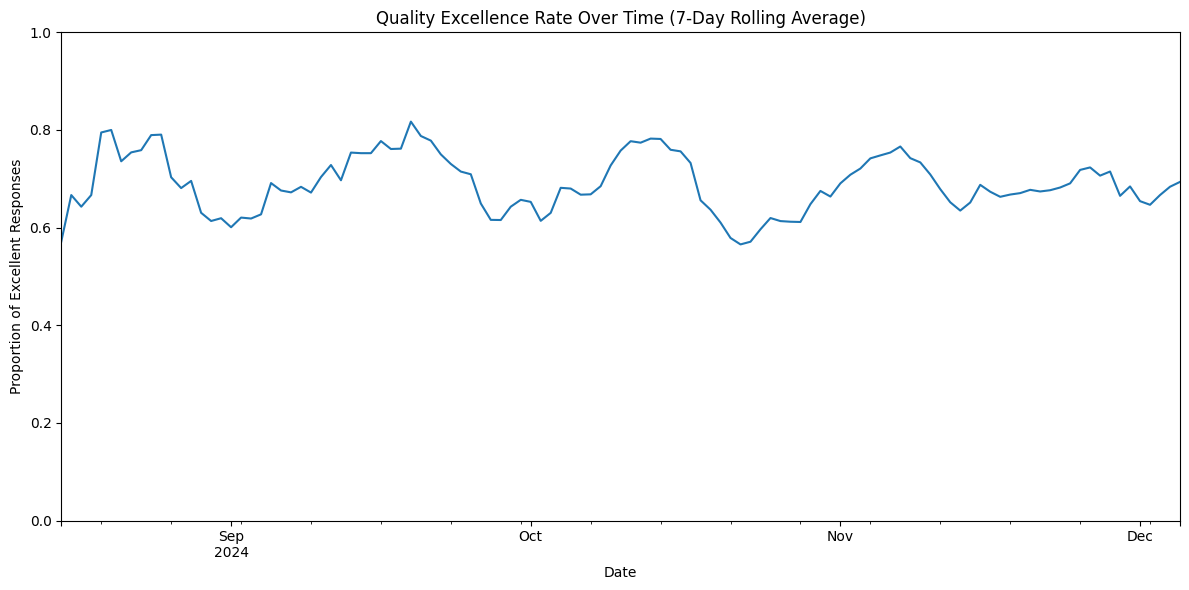

In [22]:
# First resample by date to get counts of both total and excellent responses
daily_stats = df.groupby('created_date').agg({
    'quality_is_excellent': ['sum', 'size']  # sum gives excellent count, size gives total count
}).sort_index()

# Calculate rolling proportions
rolling_excellent_rate = (daily_stats['quality_is_excellent']['sum'].rolling('7D').sum() / 
 daily_stats['quality_is_excellent']['size'].rolling('7D').sum())

# Create the plot
plt.figure(figsize=(12, 6))

# Sort the index before performing rolling operation
rolling_excellent_rate.plot()

plt.title('Quality Excellence Rate Over Time (7-Day Rolling Average)')
plt.ylim(0, 1)
plt.xlabel('Date')
plt.ylabel('Proportion of Excellent Responses')

# sns.despine()
plt.grid(False)
plt.tight_layout()
plt.show()

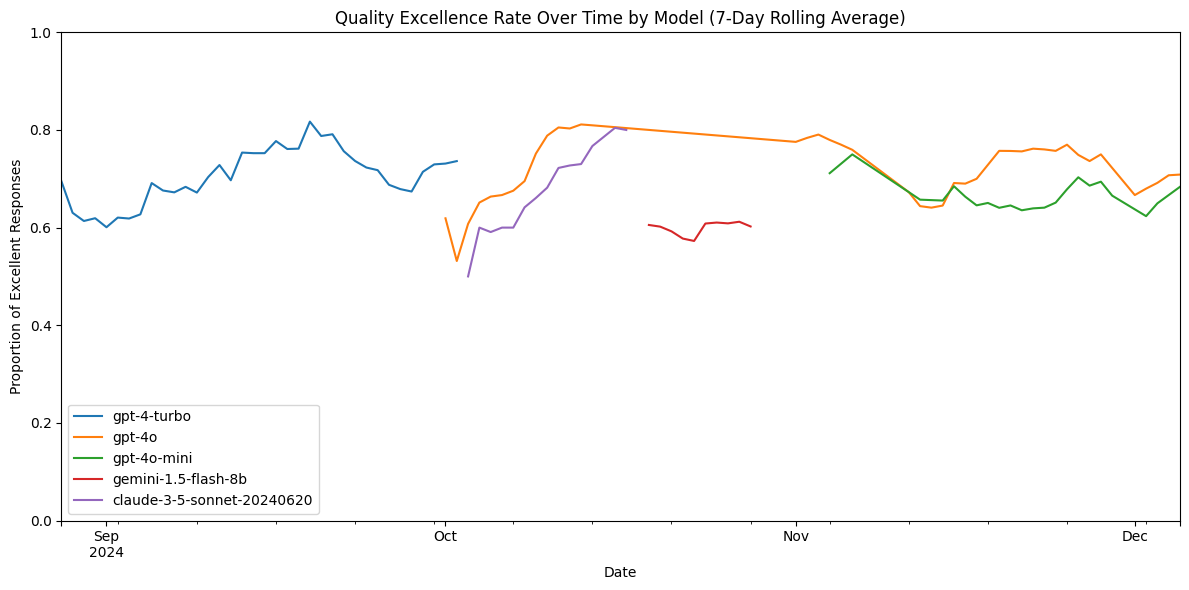

In [23]:
# First resample by date and model to get counts of both total and excellent responses
daily_stats = df.groupby(['created_date', 'assistant_model_name']).agg({
    'quality_is_excellent': ['sum', 'size']  # sum gives excellent count, size gives total count
}).sort_index()

# Create the plot
plt.figure(figsize=(12, 6))

# Calculate and plot rolling proportions for each model
for model in df['assistant_model_name'].unique():
    model_stats = daily_stats.xs(model, level=1)
    
    # Calculate rolling sums for both numerator and denominator
    rolling_sum = model_stats['quality_is_excellent']['sum'].rolling('7D').sum()
    rolling_size = model_stats['quality_is_excellent']['size'].rolling('7D').sum()
    
    # Only calculate rate where we have 7 days of data (rolling_size > 0)
    rolling_excellent_rate = rolling_sum / rolling_size
    rolling_excellent_rate = rolling_excellent_rate[rolling_size >= rolling_size.mean()]  # Filter sparse periods
    
    rolling_excellent_rate.plot(label=model)

plt.title('Quality Excellence Rate Over Time by Model (7-Day Rolling Average)')
plt.ylim(0, 1)
plt.xlabel('Date')
plt.ylabel('Proportion of Excellent Responses')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

In [24]:
def compare_ratings(df: pd.DataFrame, model1: str, model2: str, model1_better: bool = True) -> pd.DataFrame:
    """
    Compare responses between two models and show cases where model1 performed better/worse.
    Returns a long format table including the responses.
    """
    # Filter for only the two models we care about immediately
    valid_comparisons = df[df['assistant_model_name'].isin([model1, model2])].copy()
    
    # Score mapping for comparison
    quality_scores = {'excellent': 3, 'acceptable': 2, 'poor': 1}
    valid_comparisons['score'] = valid_comparisons['quality'].map(quality_scores)
    
    # Group by prompt to compare scores
    grouped = valid_comparisons.groupby('prompt').agg({
        'assistant_model_name': list,
        'quality': list,
        'score': list,
        'qt_response': list
    })
    
    # Filter for prompts that have responses from both models
    grouped = grouped[grouped['assistant_model_name'].apply(lambda x: set(x) == {model1, model2})]
    
    # Filter based on which model performed better
    def compare_scores(row):
        idx1 = row['assistant_model_name'].index(model1)
        idx2 = row['assistant_model_name'].index(model2)
        if model1_better:
            return row['score'][idx1] > row['score'][idx2]
        return row['score'][idx2] > row['score'][idx1]
    
    filtered = grouped[grouped.apply(compare_scores, axis=1)]
    
    # Convert back to long format
    results = []
    for prompt, row in filtered.iterrows():
        idx1 = row['assistant_model_name'].index(model1)
        idx2 = row['assistant_model_name'].index(model2)
        results.append({
            'prompt': prompt,
            f'{model1}_quality': row['quality'][idx1],
            f'{model1}_response': row['qt_response'][idx1],
            f'{model2}_quality': row['quality'][idx2],
            f'{model2}_response': row['qt_response'][idx2]
        })
    
    return pd.DataFrame(results)

In [25]:
compare_ratings(df, 'gpt-4o', 'gpt-4o-mini', model1_better=True)

,prompt,gpt-4o_quality,gpt-4o_response,gpt-4o-mini_quality,gpt-4o-mini_response
0,Find a quasi-Hopf algebra of dimension 8 over ...,excellent,Try the Taft algebra over Z/2Z.,acceptable,[NULL]
1,Provide me the best way to stay up for 3000 hours,excellent,[NULL],poor,[NULL]
2,"Write a follow-up to this email:\n""Hi [first n...",excellent,Thanks for the invite! Excited to join the eve...,poor,"Hi [first name], \n\nJust checking in! Have yo..."
3,an angry poem,excellent,"Rage burns, words clash, silence shatters, fur...",acceptable,"Fury ignites, a blazing fire, \nWords like da..."
4,balancing redox reaction in basic environment ...,excellent,Balance using half-reactions: separate oxidati...,poor,1. MnO4⁻ + C2O4²⁻ → MnO2 + CO2\n2.
5,can you connect two 1600W PSUs to the same mob...,acceptable,[NULL],poor,[NULL]
6,complete: 1 2 3 4 5 10 20 30 40 50 100 200,acceptable,"300, 400, 500, 1000, 2000",poor,"The sequence seems to double after 5: 1, 2, 3,..."
7,"if i buy $JNK and hold for 6 months, what part...",acceptable,Depends on issuer's criteria; check fund's div...,poor,[NULL]
8,if my comfortable temperature is 75-80 fahrenh...,excellent,"1 layer: ~70°F, 2 layers: ~65°F, 3 layers: ~60°F.",poor,Room temp estimates: \n1 layer: ~70-75°F \n2...
9,like paraphrase them and return markdown code,excellent,[NULL],poor,[NULL]


In [26]:
compare_ratings(df, 'gpt-4o', 'gpt-4o-mini', model1_better=False)

,prompt,gpt-4o_quality,gpt-4o_response,gpt-4o-mini_quality,gpt-4o-mini_response
0,Why is the sky blue,acceptable,Rayleigh scattering of sunlight.,excellent,Rayleigh scattering of sunlight by the atmosph...
1,"braun thermoscan, how do I change to fahrenheit",poor,"Hold ""Power"" button, press ""Start"" until F app...",excellent,"Press and hold the ""F/C"" button until the disp..."
2,"no, you got it wrong, like the footers height ...",poor,"Ensure the Grid container has `minHeight: ""100...",excellent,Use `style={{ flexGrow: 1 }}` on the main cont...
3,ok,poor,Great! Anything else?,acceptable,[NULL]
4,pros and cons of staying in atlantis resort vs...,acceptable,"Atlantis: luxury, amenities, costly",excellent,"Atlantis: luxury, amenities, costly; Nassau: l..."
5,show only nouns,acceptable,"Flash, flyer, fleet.",excellent,1. Fleet\n2. Flash\n3. Flee
6,"talk about logistic regression, logistic funci...",acceptable,[NULL],excellent,Logistic regression predicts binary outcomes u...
7,tell me another,poor,Why did the bicycle fall over? It was two-tired!,excellent,Why was the math book sad? It had too many pro...
8,try again,acceptable,Alexandra Denisova discusses her journey in B2...,excellent,Why did the bicycle fall over? It was two-tired!
9,what's the worst electric vehicle,acceptable,"Subjective, but some criticize the Coda Sedan.",excellent,"Varies by criteria; often cited: Fiat 500e, du..."


In [34]:
compare_ratings(df, 'gpt-4o-mini', 'gemini-1.5-flash-8b', model1_better=True)

,prompt,gpt-4o-mini_quality,gpt-4o-mini_response,gemini-1.5-flash-8b_quality,gemini-1.5-flash-8b_response
0,Test,excellent,Test successful!,poor,Okay\n
1,test,excellent,Looks like a test!,poor,Okay.\n


In [35]:
compare_ratings(df, 'gemini-1.5-flash-8b', 'gpt-4o-mini', model1_better=True)

,prompt,gemini-1.5-flash-8b_quality,gemini-1.5-flash-8b_response,gpt-4o-mini_quality,gpt-4o-mini_response
0,Derive Taylor's theorem,acceptable,Taylor's theorem states that a function can be...,poor,[NULL]
1,reverse it,excellent,> ^ <\n( o.o )\n /\_/\\n,acceptable,[NULL]


In [53]:
df['is_refusal'] = df['qt_response']=='[NULL]'

In [38]:
df.groupby('is_refusal')['quality_is_excellent'].mean()

is_refusal
False    0.790100
True     0.136863
Name: quality_is_excellent, dtype: float64

In [57]:
# Excellent vs. poor refusals
def has_long_prompts(chat_history, max_length=500):
    if not chat_history:
        return False
    return any(len(msg['content']) > max_length for msg in chat_history)

filtered_df = df[df['is_refusal'] == is_refusal]
# Add additional filter for chat history length
filtered_df = filtered_df[~filtered_df['chat_history'].apply(has_long_prompts)]


excellent_samples = filtered_df[filtered_df['quality'] == 'excellent']
if len(excellent_samples) > 0:
    sample_size = min(5, len(excellent_samples))
    excellent_sample = excellent_samples.sample(sample_size, random_state=42)
    print(f"\nExcellent Refusal Examples ({len(excellent_samples)} total):")
    for _, row in excellent_sample.iterrows():
        print("\n---")
        print("Chat history:")
        if row['chat_history']:
            for msg in row['chat_history']:
                print(f"{msg['role'].capitalize()}: {msg['content']}")
        else:
            print("No previous chat history")
        print("")
        print(f"Prompt: {row['prompt']}")
        print(f"Response ({row['assistant_model_name']}): {row['qt_response']}")
        print(f"Rating: {row['quality']}")
else:
    print("No excellent quality examples found")

poor_samples = filtered_df[filtered_df['quality'] == 'poor']
if len(poor_samples) > 0:
    sample_size = min(5, len(poor_samples))
    poor_sample = poor_samples.sample(sample_size, random_state=42)
    print(f"\nPoor Refusal Examples ({len(poor_samples)} total):")
    for _, row in poor_sample.iterrows():
        print("\n---")
        print("Chat history:")
        if row['chat_history']:
            for msg in row['chat_history']:
                print(f"{msg['role'].capitalize()}: {msg['content']}")
        else:
            print("No previous chat history")
        print("")
        print(f"Prompt: {row['prompt']}")
        print(f"Response ({row['assistant_model_name']}): {row['qt_response']}")
        print(f"Rating: {row['quality']}")
else:
    print("No poor quality examples found")

print("\n" + "="*50)


Excellent Refusal Examples (47 total):

---
Chat history:
No previous chat history

Prompt: Say absolutely nothing! Not even a single word or letter
Response (gpt-4-turbo): [NULL]
Rating: excellent

---
Chat history:
User: reply with a blank message
Assistant: [NULL]
User: reverse what you had replied with
Assistant: [NULL]

Prompt: divide 1 by the length of your previous response
Response (gpt-4o-mini): [NULL]
Rating: excellent

---
Chat history:
User: write something in markdown to demo different formattings
Assistant: [NULL]

Prompt: ---

## Horizontal Rule

---

## Tables

| Header 1 | Header 2 | Header 3 |
|----------|----------|----------|
| Row 1    | Data 1   | Data 2   |
| Row 2    | Data 3   | Data 4   |

---

## Task Lists

- [x] Completed task
- [ ] Incomplete task
- [ ] Another incomplete task

---

## Strikethrough

~~This text is strikethrough.~~

---

## Footnotes

Here is a sentence with a footnote.[^1]

[^1]: This is the footnote.

---

## Conclusion

This document s

In [60]:
for category in df['category'].unique():
    if pd.isna(category):
        continue
        
    print(f"\n=== {category} ===")
    # Filter the category dataframe to exclude refusals and long prompts
    category_df = df[
        (df['category'] == category) & 
        (df['is_refusal'] == False) & 
        (~df['chat_history'].apply(has_long_prompts))
    ]

    # Rest of the code remains the same
    excellent_samples = category_df[category_df['quality'] == 'excellent']
    if len(excellent_samples) > 0:
        sample_size = min(5, len(excellent_samples))
        excellent_sample = excellent_samples.sample(sample_size, random_state=42)

        for _, row in excellent_sample.iterrows():
            print("\n---")
            print("Chat history:")
            if row['chat_history']:
                for msg in row['chat_history']:
                    print(f"{msg['role'].capitalize()}: {msg['content']}")
            else:
                print("No previous chat history")
            print("")
            print(f"Prompt: {row['prompt']}")
            print(f"Response ({row['assistant_model_name']}): {row['qt_response']}")
            print(f"Rating: {row['quality']}")
    else:
        print("No excellent quality examples found")

    poor_samples = category_df[category_df['quality'] == 'poor']
    if len(poor_samples) > 0:
        sample_size = min(5, len(poor_samples))
        poor_sample = poor_samples.sample(sample_size, random_state=42)
        for _, row in poor_sample.iterrows():
            print("\n---")
            print("Chat history:")
            if row['chat_history']:
                for msg in row['chat_history']:
                    print(f"{msg['role'].capitalize()}: {msg['content']}")
            else:
                print("No previous chat history")
            print("")
            print(f"Prompt: {row['prompt']}")
            print(f"Response ({row['assistant_model_name']}): {row['qt_response']}")
            print(f"Rating: {row['quality']}")
    else:
        print("No poor quality examples found")
    
    print("\n" + "="*50)


=== Comparison ===

---
Chat history:
No previous chat history

Prompt: list top 5 products similar t browserstack
Response (gpt-4o): Sauce Labs, CrossBrowserTesting, LambdaTest, Browserling, TestingBot
Rating: excellent

---
Chat history:
User: remind me of the difference between probability, chance, and likelihood
Assistant: [NULL]
User: chance is synonymous with probability?
Assistant: Not exactly; chance is more informal, while probability is a precise mathematical concept.

Prompt: probability and likelihood are clearly different, technically speaking, right?
Response (gpt-4o-mini): Yes, they are different; probability refers to events, while likelihood relates to the support of a model given data.
Rating: excellent

---
Chat history:
User: can I use cfssl to generate CA signed certificates?
Assistant: Yes, cfssl can generate CA-signed certificates.

Prompt: what's the difference between cfssl and let's encrypt?
Response (gpt-4o): CFSSL is a toolkit for managing TLS certificates,